Measurement in the ZZ basis


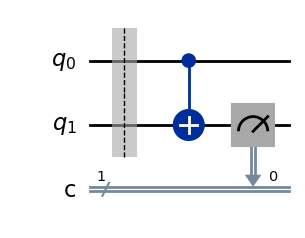

In [29]:
import qiskit as qk

qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the ZZ basis")
qc.draw(output="mpl")

Measurement in the XX basis


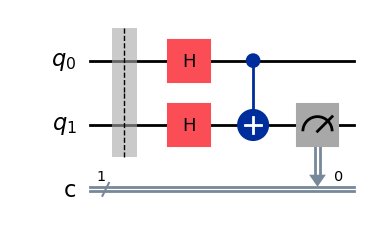

In [30]:
qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the XX basis")
qc.draw(output="mpl")

Measurement in the YY basis


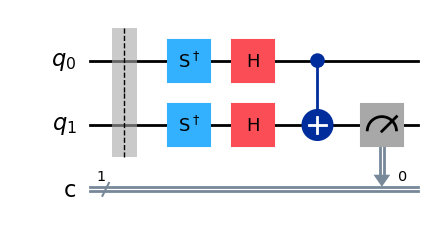

In [31]:
qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.sdg(0)
qc.sdg(1)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the YY basis")
qc.draw(output="mpl")

In [32]:
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from numpy import pi

sim_bknd = Aer.get_backend('qasm_simulator')

In [33]:
def ansatz(qc, qr, theta):
    """
    Builds the trial state using the ansatz: (RX I) CX (H I)|00>
    
    Arguments
    -----------
    qc: is a QuantumCircuit object from Qiskit
    qr: is a QuantumRegister object used in the quantum circuit qc
    theta (real): is the parameter parametrizing the trial state
    
    Return
    ---------
    qc: returns the input quantum circuit added with the gates creating the trial state
    
    """
    
    qc.h(qr[0])
    qc.cx(qr[0],qr[1])
    qc.rx(theta, qr[0])
    
    return qc

def measurements(qc, qr, cr, op):
    """
    Implements the quantum measurements in different basis: XX, YY and ZZ.
    
    Arguments
    -----------
    qc: is a QuantumCircuit object from Qiskit
    qr: is a QuantumRegister object used in the quantum circuit qc
    cr: is a ClassicalRegister object used in the quantum circuit qc
    op (str): is a string with possible values: XX, YY and ZZ.
    
    
    Return
    ---------
    qc: returns the input quantum circuit added with the appropriate gates to measure in the selected basis.
    
    """
    
    if op == "XX":
        # Change of basis, since X = HZH
        qc.h(qr[0])
        qc.h(qr[1])
        
        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])
        
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])
        
    elif op == "YY":
        # Change of basis, since Y = (HS†)Z(HS†)
        qc.sdg(qr[0])
        qc.sdg(qr[1])
        qc.h(qr[0])
        qc.h(qr[1])
        
        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])
        
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])
        
    elif op == "ZZ":
        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])
        
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])
    
    else:
        print(f"WARNING: Measurement on the {op} basis not supported")
        return 
        
    return qc

def hamiltonian(params):
    """
    Evaulates the Energy of the trial state using the mean values of the operators XX, YY and ZZ.
    
    Arguments
    -----------
    params (dict): is an dictionary containing the mean values form the measurements of the operators XX, YY, ZZ;
    
    Return
    ---------
    en (real): energy of the system
    
    """
    # H = 1/2 * (Id + ZZ - XX - YY)
    en = (1 + params['ZZ'] - params['XX'] - params['YY']) / 2
    return en

def vqe_step(theta, verbose = True):
    """
    Executes the VQE algorithm. 
    Creates and executes three quantum circuits (one for each of the observables XX, YY and ZZ), then evaluates the energy.
    
    Arguments
    -----------
    theta (real): is the parameter parametrizing the trial state
    
    Return
    --------
    energy (real): the energy of the system
    qc_list (dict): a dictionary containing the three quantum circuits for the observables XX, YY and ZZ
    
    """
    # Number of executions for each quantum circuit
    shots=8192
    
    vqe_res = dict()
    qc_list = dict()
    
    for op in ["XX", "YY", "ZZ"]:
        qr = qk.QuantumRegister(2, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (XX, YY, ZZ) are implemented
        qc = measurements(qc, qr, cr, op)
                
        # Get the measurements results
        counts = sim_bknd.run(qc, shots=shots).result().get_counts()

        # Check the results, and evaluate the mean value dividing by the number of shots
        if len(counts) == 1: 
            try:
                counts['0']
                mean_val = 1
            except:
                mean_val = -1
        else:
            # Evaluates the mean value of Z operator, as the difference in the number of 
            # 0s and 1s in the measurement outcomes
            mean_val = (counts['0']-counts['1'])/shots
            
        vqe_res[op] = mean_val
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
        print(f"\n{'Theta':<10} {'Energy':<10} {'<XX>':<10} {'<YY>':<10} {'<ZZ>':<10}")
        print(f"{theta:<10f} {energy:<10f} {vqe_res['XX']:<10f} {vqe_res['YY']:<10f} {vqe_res['ZZ']:<10f}")
    
        return energy, qc_list
    
    else: 
        return energy

Mean values from measurement results:
 {'XX': 1, 'YY': -0.983642578125, 'ZZ': 0.982421875}

Theta      Energy     <XX>       <YY>       <ZZ>      
0.200000   0.983032   1.000000   -0.983643  0.982422  

Quantum circuit for the measurement of YY


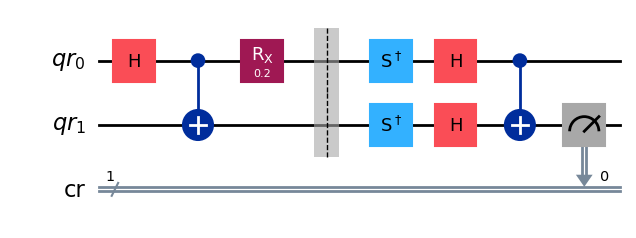

In [34]:
# Set the value of theta
theta = 0.2

# Run the VQE step to evaluate the energy (eigenvalue of the Hamiltonian) of the state with given theta
energy, qc_list = vqe_step(theta)

# Plot the circuit used for the measurement of YY
op = 'YY'
print(f"\nQuantum circuit for the measurement of {op}")
qc_list[op].draw(output="mpl")